In [100]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_rel, mannwhitneyu, shapiro

In [101]:
# Import the data
df = pd.read_csv(r'C:\Users\Lindsay\Github\MEA_data\Before Hypoxia Plate 4(001)(000)_spike_counts.csv')

In [102]:
# Deleting empty columns
df = df.dropna(axis=1, how='all')

# deleting the unnamed column
df = df.drop('Unnamed: 2', axis=1)

df.head()

,Interval Start (S),Interval End (S),A1,A1_11,A1_12,A1_13,A1_14,A1_15,A1_16,A1_17,...,A1_77,A1_78,A1_81,A1_82,A1_83,A1_84,A1_85,A1_86,A1_87,A1_88
0,00000.000000,00001.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00001.000000,00002.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00002.000000,00003.000000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00003.000000,00004.000000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00004.000000,00005.000000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The highlighted text is a line of Python code that uses the `dropna` method from the pandas library to remove columns from a DataFrame (`df`) that contain only `NaN` (Not a Number) values.

Explanation:
`df.dropna(axis=1, how='all')`:
`df`: The DataFrame from which columns are being removed.
`dropna`: A method to remove missing values.
`axis=1`: Specifies that the operation should be performed on columns (if `axis=0`, it would operate on rows).
`how='all'`: Specifies that only columns where all values are NaN should be removed.

In [103]:
# Check the data types
print('Before converting the data types:')
print("Data type of 'Interval Start (S)':", type(df['Interval Start (S)'][0]))
print("Data type of 'Interval End (S)':", type(df['Interval End (S)'][0]))
print("Data type of 'A1_11':", type(df['A1_11'][0]))

# Python is seeing the intervals as strings instead of floats

Before converting the data types:
Data type of 'Interval Start (S)': <class 'str'>
Data type of 'Interval End (S)': <class 'str'>
Data type of 'A1_11': <class 'numpy.float64'>


In [104]:
# Convert the columns to numeric types
df['Interval Start (S)'] = pd.to_numeric(df['Interval Start (S)'], errors='coerce')
df['Interval End (S)'] = pd.to_numeric(df['Interval End (S)'], errors='coerce')

# Ensure the values are numerical
interval_start = df['Interval Start (S)'].iloc[0]
interval_end = df['Interval End (S)'].iloc[0]

# Check the data types
print("Data type of 'Interval Start (S)':", interval_start, type(interval_start))
print("Data type of 'Interval End (S)':", interval_end, type(interval_end))

Data type of 'Interval Start (S)': 0.0 <class 'numpy.float64'>
Data type of 'Interval End (S)': 1.0 <class 'numpy.float64'>


The +1 is added to the `interval_end.max()` to ensure that the last interval end is included in the range of time bins. This is because np.arange generates values in the half-open interval `[start, stop)`, meaning it includes the start value but excludes the stop value. By adding `+1` to `interval_end.max()`, you ensure that the last interval end is included in the time bins.

In [105]:
# Define the bin width (e.g., 1 s)
bin_width = 1.0

# Columns to process
columns_to_process = df.columns[3:].tolist()

print(columns_to_process)

# Initialize a dictionary to accumulate spike counts for each column
spike_counts = {col: {} for col in columns_to_process}


['A1_11', 'A1_12', 'A1_13', 'A1_14', 'A1_15', 'A1_16', 'A1_17', 'A1_18', 'A1_21', 'A1_22', 'A1_23', 'A1_24', 'A1_25', 'A1_26', 'A1_27', 'A1_28', 'A1_31', 'A1_32', 'A1_33', 'A1_34', 'A1_35', 'A1_36', 'A1_37', 'A1_38', 'A1_41', 'A1_42', 'A1_43', 'A1_44', 'A1_45', 'A1_46', 'A1_47', 'A1_48', 'A1_51', 'A1_52', 'A1_53', 'A1_54', 'A1_55', 'A1_56', 'A1_57', 'A1_58', 'A1_61', 'A1_62', 'A1_63', 'A1_64', 'A1_65', 'A1_66', 'A1_67', 'A1_68', 'A1_71', 'A1_72', 'A1_73', 'A1_74', 'A1_75', 'A1_76', 'A1_77', 'A1_78', 'A1_81', 'A1_82', 'A1_83', 'A1_84', 'A1_85', 'A1_86', 'A1_87', 'A1_88']


In [106]:
# Initialize spike_counts dictionary
spike_counts = {col: {} for col in columns_to_process}

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    interval_start = row['Interval Start (S)']
    interval_end = row['Interval End (S)']
    
    for col in columns_to_process:
        spike_count = row[col]
        
        # Define the time bins for the current interval
        try:
            time_bins = np.arange(interval_start, interval_end + bin_width, bin_width)
        except ValueError as e:
            continue
        
        # Accumulate spike counts in the bins
        for bin_start in time_bins[:-1]:
            if bin_start not in spike_counts[col]:
                spike_counts[col][bin_start] = 0
            spike_counts[col][bin_start] += spike_count

# Convert the dictionaries to sorted lists of bins and counts
sorted_bins = {col: sorted(spike_counts[col].keys()) for col in columns_to_process}
sorted_counts = {col: [spike_counts[col][bin_start] for bin_start in sorted_bins[col]] for col in columns_to_process}

print(sorted_bins)
print(sorted_counts)

{'A1_11': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 

In [107]:
# Determine the number of columns to process
num_columns = len(columns_to_process)

# Calculate the number of rows and columns for the subplot grid
num_cols = math.ceil(math.sqrt(num_columns))  # Number of columns in the grid
num_rows = math.ceil(num_columns / num_cols)  # Calculate the number of rows needed

print("Number of rows:", num_rows)
print("Number of columns:", num_columns)


Number of rows: 8
Number of columns: 64


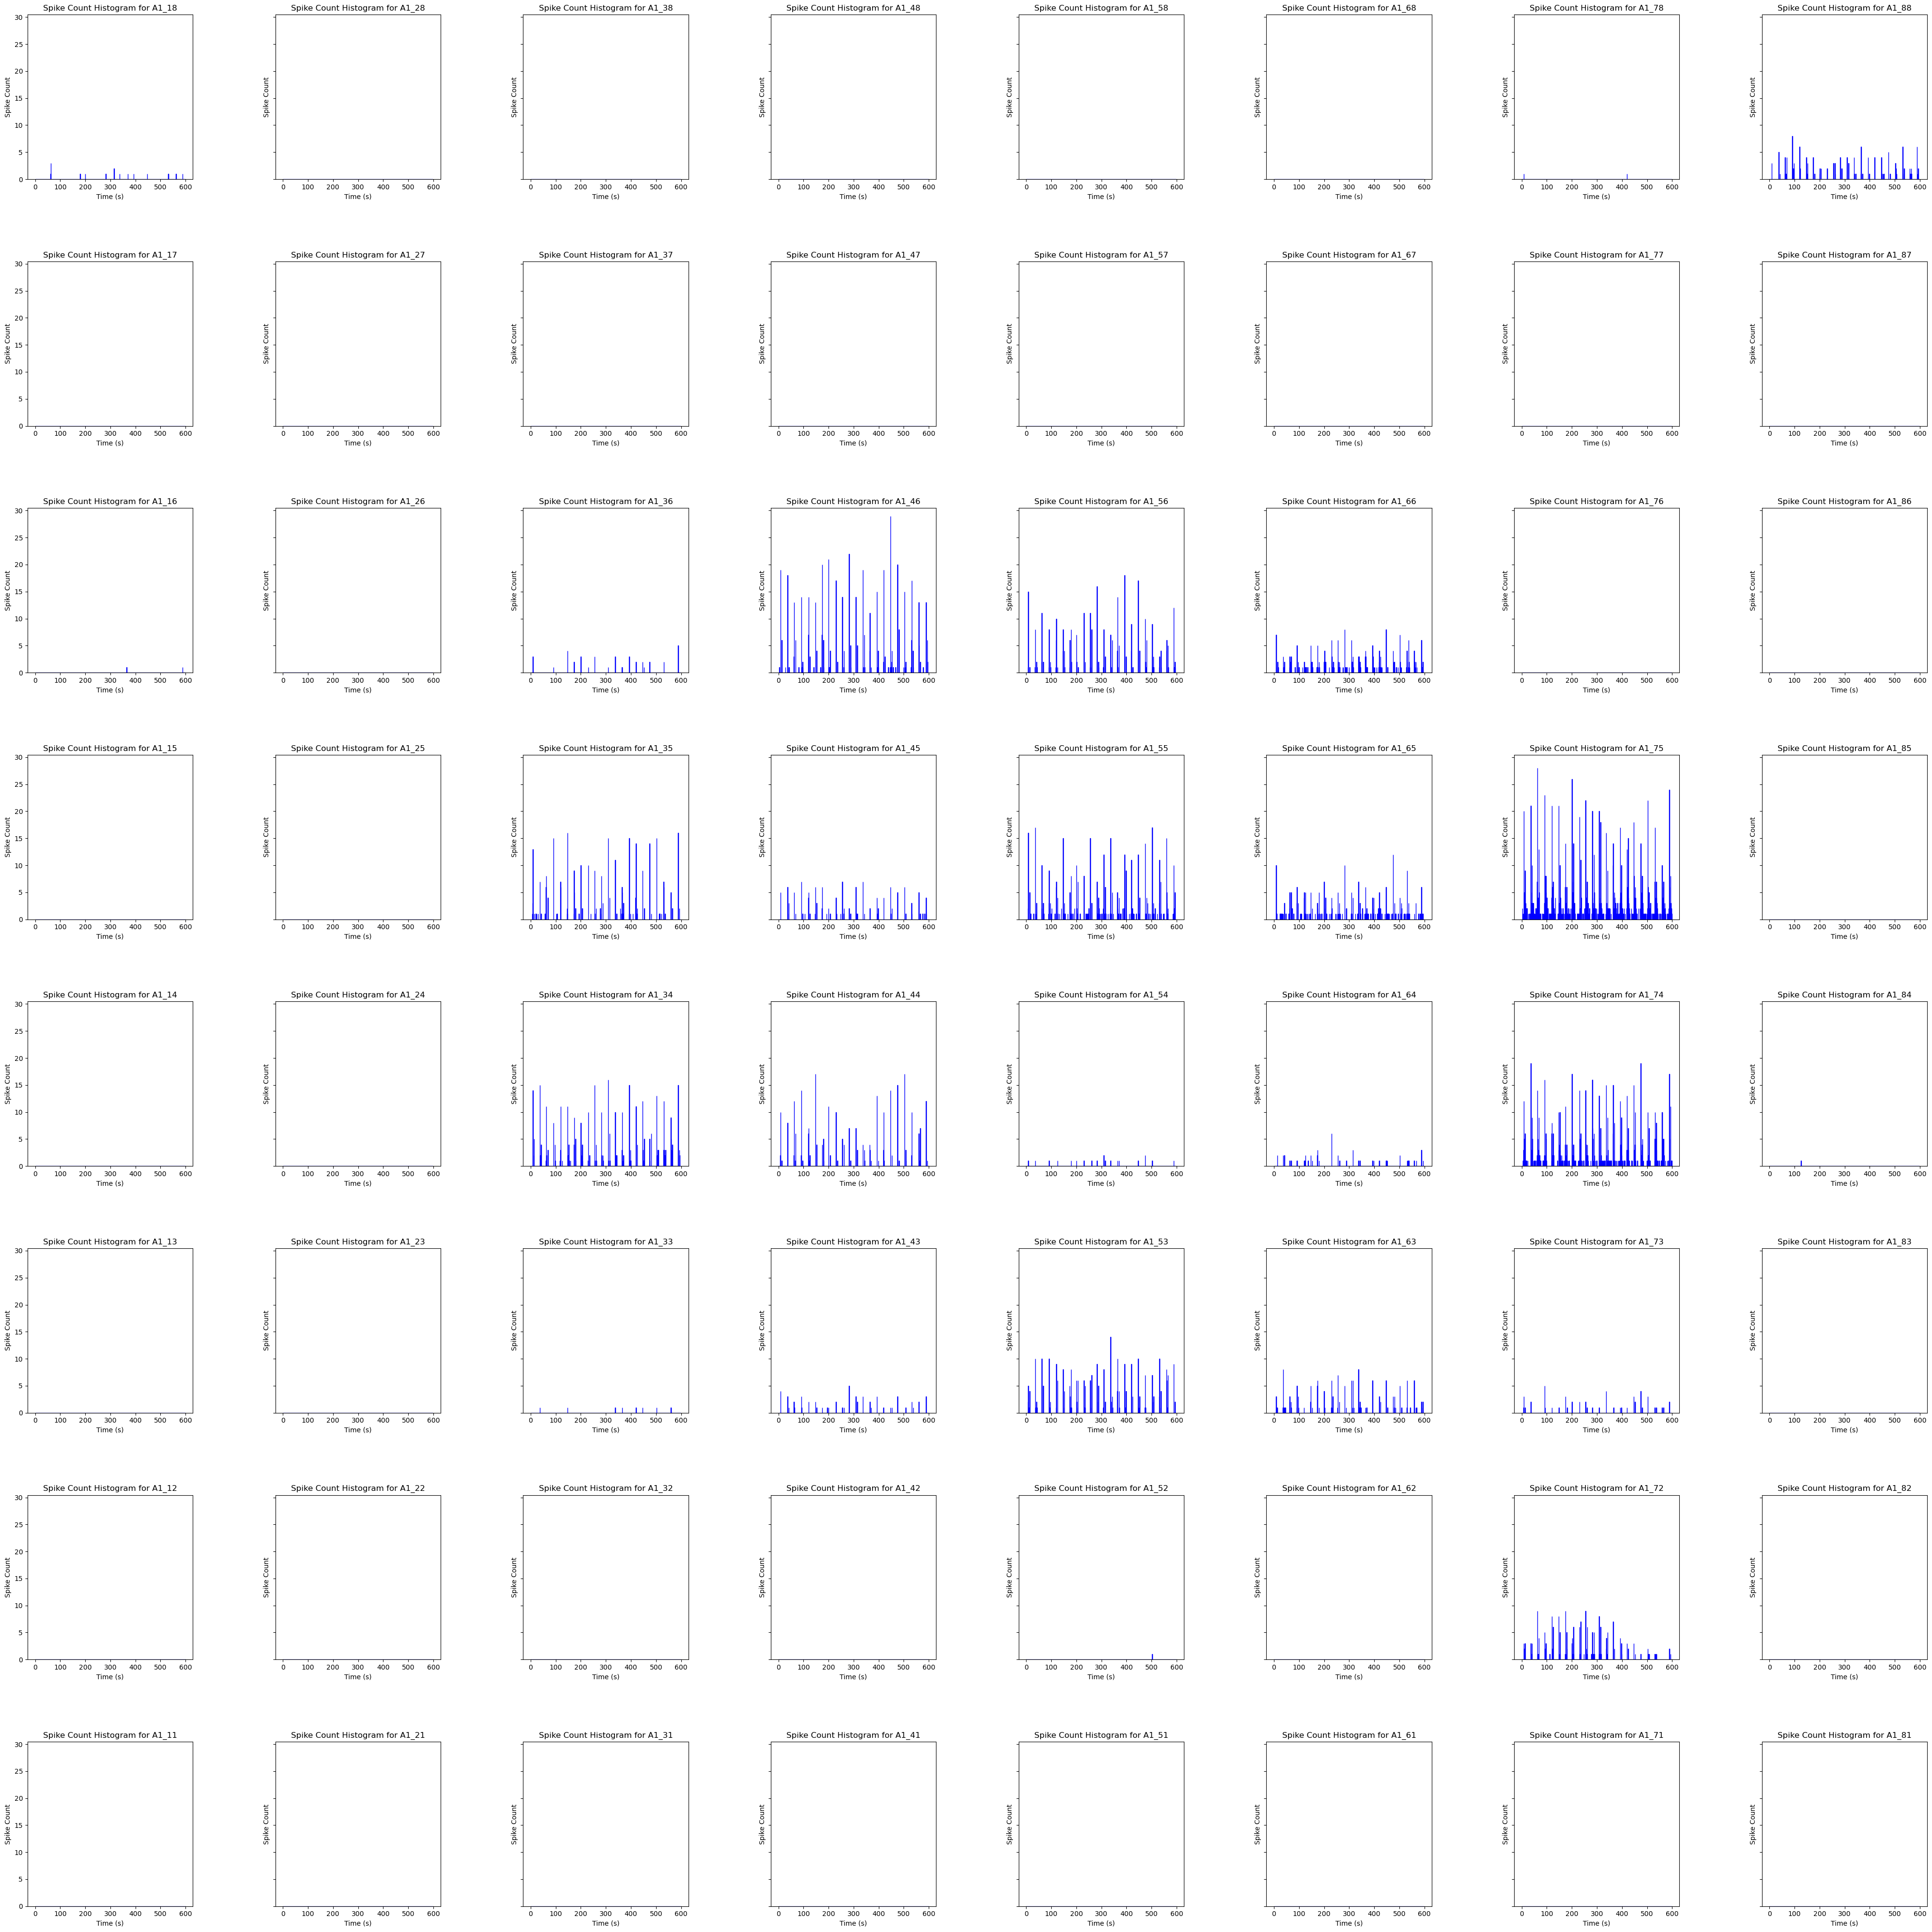

In [108]:
# Create a figure and an array of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5), sharey=True)

# Ensure axs is always an array
if not isinstance(axs, np.ndarray):
    axs = np.array([axs])

# Flatten the array of subplots for easy iteration
axs = axs.flatten()

# Loop through each column to process
for index, col in enumerate(columns_to_process, 0):  # had to make this 0 bc it's usually 1
    # Calculate the row and column index for the subplot
    row_idx = num_rows - 1 - (index % num_rows)  # Reverse the row index
    col_idx = index // num_rows

    # Calculate the subplot index
    subplot_index = row_idx * num_cols + col_idx

    # Create a subplot for each column
    ax = axs[subplot_index]
    ax.hist(sorted_bins[col], bins=len(sorted_bins[col]), weights=sorted_counts[col], edgecolor='blue')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Spike Count')
    ax.set_title(f'Spike Count Histogram for {col}')

    # # Add a vertical span (vspan) to highlight a region
    # vspan_start = 1  # Start position of the vertical span
    # vspan_end = 300    # End position of the vertical span
    # ax.axvspan(vspan_start, vspan_end, color='lightgrey', alpha=0.5, zorder = 1)
    
# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Fine-tune the spacing
plt.show()

## Comparing the mean firing rate of each electrode

In [109]:
mean_firing_rate = {}
first_segment_duration = 300
last_segment_duration = 200

for col in columns_to_process:
    # Calculate total duration
    total_duration = sorted_bins[col][-1] - sorted_bins[col][0] + bin_width  # Assuming bins are in seconds

    # Determine the indices for the first and last segments
    first_segment_end_idx = np.searchsorted(sorted_bins[col], first_segment_duration)
    last_segment_start_idx = np.searchsorted(sorted_bins[col], total_duration - last_segment_duration)

    # Calculate the mean firing rate for the first 300 seconds
    first_segment_spikes = sum(sorted_counts[col][:first_segment_end_idx])
    first_segment_total_duration = sorted_bins[col][first_segment_end_idx - 1] - sorted_bins[col][0] + bin_width
    first_segment_mean_firing_rate = round(first_segment_spikes / first_segment_total_duration, 2) if first_segment_total_duration > 0 else 0

    # Calculate the mean firing rate for the last 200 seconds
    last_segment_spikes = sum(sorted_counts[col][last_segment_start_idx:])
    last_segment_total_duration = sorted_bins[col][-1] - sorted_bins[col][last_segment_start_idx] + bin_width
    last_segment_mean_firing_rate = round(last_segment_spikes / last_segment_total_duration, 2) if last_segment_total_duration > 0 else 0

    # Store the results in the dictionary
    mean_firing_rate[col] = {
        'first_300_seconds': first_segment_mean_firing_rate,
        'last_200_seconds': last_segment_mean_firing_rate
    }

print(mean_firing_rate)

{'A1_11': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_12': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_13': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_14': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_15': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_16': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_17': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_18': {'first_300_seconds': 0.02, 'last_200_seconds': 0.02}, 'A1_21': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_22': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_23': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_24': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_25': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_26': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_27': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_28': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_3

In [110]:
# Change the duration of the first and last segments here
mean_firing_rate = {}
first_segment_duration = 300
last_segment_duration = 200

# Initialize lists to store the mean firing rates
first_segment_means = []
last_segment_means = []
columns = []

for col in columns_to_process:
    # Calculate total duration
    total_duration = sorted_bins[col][-1] - sorted_bins[col][0] + bin_width  # Assuming bins are in seconds

    # Determine the indices for the first and last segments
    first_segment_end_idx = np.searchsorted(sorted_bins[col], first_segment_duration)
    last_segment_start_idx = np.searchsorted(sorted_bins[col], total_duration - last_segment_duration)

    # Calculate the mean firing rate for the first segment
    first_segment_spikes = sum(sorted_counts[col][:first_segment_end_idx])
    first_segment_total_duration = sorted_bins[col][first_segment_end_idx - 1] - sorted_bins[col][0] + bin_width
    first_segment_mean_firing_rate = round(first_segment_spikes / first_segment_total_duration, 2) if first_segment_total_duration > 0 else 0

    # Calculate the mean firing rate for the last segment
    last_segment_spikes = sum(sorted_counts[col][last_segment_start_idx:])
    last_segment_total_duration = sorted_bins[col][-1] - sorted_bins[col][last_segment_start_idx] + bin_width
    last_segment_mean_firing_rate = round(last_segment_spikes / last_segment_total_duration, 2) if last_segment_total_duration > 0 else 0

    # Append the results to the lists
    first_segment_means.append(first_segment_mean_firing_rate)
    last_segment_means.append(last_segment_mean_firing_rate)
    columns.append(col)

# Convert the lists to NumPy arrays
first_segment_means_array = np.array(first_segment_means)
last_segment_means_array = np.array(last_segment_means)
columns_array = np.array(columns)

# Create adaptable field names based on the durations
first_segment_field = f'first_{first_segment_duration}_seconds'
last_segment_field = f'last_{last_segment_duration}_seconds'

# Create a structured NumPy array to match the columns to the mean firing rates
dtype = [
    ('column', 'U20'), 
    (first_segment_field, 'f4'), 
    (last_segment_field, 'f4')
]
mean_firing_rate_array = np.zeros(len(columns), dtype=dtype)
mean_firing_rate_array['column'] = columns_array
mean_firing_rate_array[first_segment_field] = first_segment_means_array
mean_firing_rate_array[last_segment_field] = last_segment_means_array


# Print the structured NumPy array
print(mean_firing_rate_array)
print("The size of the mean_firing_rate_array is:", mean_firing_rate_array.size)

[('A1_11', 0.  , 0.  ) ('A1_12', 0.  , 0.  ) ('A1_13', 0.  , 0.  )
 ('A1_14', 0.  , 0.  ) ('A1_15', 0.  , 0.  ) ('A1_16', 0.  , 0.  )
 ('A1_17', 0.  , 0.  ) ('A1_18', 0.02, 0.02) ('A1_21', 0.  , 0.  )
 ('A1_22', 0.  , 0.  ) ('A1_23', 0.  , 0.  ) ('A1_24', 0.  , 0.  )
 ('A1_25', 0.  , 0.  ) ('A1_26', 0.  , 0.  ) ('A1_27', 0.  , 0.  )
 ('A1_28', 0.  , 0.  ) ('A1_31', 0.  , 0.  ) ('A1_32', 0.  , 0.  )
 ('A1_33', 0.01, 0.02) ('A1_34', 0.66, 0.68) ('A1_35', 0.55, 0.52)
 ('A1_36', 0.06, 0.07) ('A1_37', 0.  , 0.  ) ('A1_38', 0.  , 0.  )
 ('A1_41', 0.  , 0.  ) ('A1_42', 0.  , 0.  ) ('A1_43', 0.11, 0.08)
 ('A1_44', 0.49, 0.55) ('A1_45', 0.27, 0.22) ('A1_46', 0.86, 0.92)
 ('A1_47', 0.  , 0.  ) ('A1_48', 0.  , 0.  ) ('A1_51', 0.  , 0.  )
 ('A1_52', 0.  , 0.  ) ('A1_53', 0.53, 0.51) ('A1_54', 0.03, 0.02)
 ('A1_55', 0.76, 0.82) ('A1_56', 0.58, 0.6 ) ('A1_57', 0.  , 0.  )
 ('A1_58', 0.  , 0.  ) ('A1_61', 0.  , 0.  ) ('A1_62', 0.  , 0.  )
 ('A1_63', 0.29, 0.26) ('A1_64', 0.12, 0.09) ('A1_65', 0.51, 0

In [111]:
import numpy as np
from scipy.stats import ttest_rel, wilcoxon, pearsonr, spearmanr

# Assuming sorted_counts, sorted_bins, columns_to_process, and bin_width are already defined

sorted_counts = {col: [spike_counts[col][bin_start] for bin_start in sorted_bins[col]] for col in columns_to_process}

# Convert the sorted lists to NumPy arrays
sorted_bins_np = {col: np.array(sorted_bins[col]) for col in columns_to_process}
sorted_counts_np = {col: np.array(sorted_counts[col]) for col in columns_to_process}

mean_firing_rate = {}
first_segment_duration = 300
last_segment_duration = 200

first_segment_means_array = []
first_segment_spike_counts = []
last_segment_means_array = []
last_segment_spike_counts = []

In [112]:
for col in columns_to_process:
    # Calculate total duration
    total_duration = sorted_bins_np[col][-1] - sorted_bins_np[col][0] + bin_width  # Assuming bins are in seconds

    # Determine the indices for the first and last segments
    first_segment_end_idx = np.searchsorted(sorted_bins_np[col], first_segment_duration)
    last_segment_start_idx = np.searchsorted(sorted_bins_np[col], total_duration - last_segment_duration)

    # Calculate the mean firing rate for the first 300 seconds
    first_segment_spikes = sum(sorted_counts_np[col][:first_segment_end_idx])
    first_segment_total_duration = sorted_bins_np[col][first_segment_end_idx - 1] - sorted_bins_np[col][0] + bin_width
    first_segment_mean_firing_rate = round(first_segment_spikes / first_segment_total_duration, 2) if first_segment_total_duration > 0 else 0

    # Calculate the mean firing rate for the last 200 seconds
    last_segment_spikes = sum(sorted_counts_np[col][last_segment_start_idx:])
    last_segment_total_duration = sorted_bins_np[col][-1] - sorted_bins_np[col][last_segment_start_idx] + bin_width
    last_segment_mean_firing_rate = round(last_segment_spikes / last_segment_total_duration, 2) if last_segment_total_duration > 0 else 0

    # Store the results in the dictionary
    mean_firing_rate[col] = {
        'first_300_seconds': first_segment_mean_firing_rate,
        'last_200_seconds': last_segment_mean_firing_rate
    }

    # Store the segment means and spike counts in arrays
    first_segment_means_array.append(first_segment_mean_firing_rate)
    first_segment_spike_counts.append(first_segment_spikes)
    last_segment_means_array.append(last_segment_mean_firing_rate)
    last_segment_spike_counts.append(last_segment_spikes)

print(mean_firing_rate)

{'A1_11': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_12': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_13': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_14': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_15': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_16': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_17': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_18': {'first_300_seconds': 0.02, 'last_200_seconds': 0.02}, 'A1_21': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_22': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_23': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_24': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_25': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_26': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_27': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_28': {'first_300_seconds': 0.0, 'last_200_seconds': 0.0}, 'A1_3

In [113]:
# Convert the segment means and spike counts into a NumPy array for easier manipulation
data = [
    (
        col, 
        first_segment_means_array[i], 
        first_segment_spike_counts[i], 
        last_segment_means_array[i], 
        last_segment_spike_counts[i]
    )
    for i, col in enumerate(columns_to_process)
]

print(data)

[('A1_11', 0.0, 0.0, 0.0, 0.0), ('A1_12', 0.0, 0.0, 0.0, 0.0), ('A1_13', 0.0, 0.0, 0.0, 0.0), ('A1_14', 0.0, 0.0, 0.0, 0.0), ('A1_15', 0.0, 0.0, 0.0, 0.0), ('A1_16', 0.0, 0.0, 0.0, 1.0), ('A1_17', 0.0, 0.0, 0.0, 0.0), ('A1_18', 0.02, 7.0, 0.02, 5.0), ('A1_21', 0.0, 0.0, 0.0, 0.0), ('A1_22', 0.0, 0.0, 0.0, 0.0), ('A1_23', 0.0, 0.0, 0.0, 0.0), ('A1_24', 0.0, 0.0, 0.0, 0.0), ('A1_25', 0.0, 0.0, 0.0, 0.0), ('A1_26', 0.0, 0.0, 0.0, 0.0), ('A1_27', 0.0, 0.0, 0.0, 0.0), ('A1_28', 0.0, 0.0, 0.0, 0.0), ('A1_31', 0.0, 0.0, 0.0, 0.0), ('A1_32', 0.0, 0.0, 0.0, 0.0), ('A1_33', 0.01, 2.0, 0.02, 5.0), ('A1_34', 0.66, 198.0, 0.68, 136.0), ('A1_35', 0.55, 165.0, 0.52, 105.0), ('A1_36', 0.06, 17.0, 0.07, 14.0), ('A1_37', 0.0, 0.0, 0.0, 0.0), ('A1_38', 0.0, 0.0, 0.0, 0.0), ('A1_41', 0.0, 0.0, 0.0, 0.0), ('A1_42', 0.0, 0.0, 0.0, 0.0), ('A1_43', 0.11, 34.0, 0.08, 15.0), ('A1_44', 0.49, 148.0, 0.55, 110.0), ('A1_45', 0.27, 82.0, 0.22, 43.0), ('A1_46', 0.86, 259.0, 0.92, 185.0), ('A1_47', 0.0, 0.0, 0.0, 0.0)

In [114]:
# Convert the list of tuples to a NumPy array
data_array = np.array(data, dtype=object)

print(data_array)

[['A1_11' 0.0 0.0 0.0 0.0]
 ['A1_12' 0.0 0.0 0.0 0.0]
 ['A1_13' 0.0 0.0 0.0 0.0]
 ['A1_14' 0.0 0.0 0.0 0.0]
 ['A1_15' 0.0 0.0 0.0 0.0]
 ['A1_16' 0.0 0.0 0.0 1.0]
 ['A1_17' 0.0 0.0 0.0 0.0]
 ['A1_18' 0.02 7.0 0.02 5.0]
 ['A1_21' 0.0 0.0 0.0 0.0]
 ['A1_22' 0.0 0.0 0.0 0.0]
 ['A1_23' 0.0 0.0 0.0 0.0]
 ['A1_24' 0.0 0.0 0.0 0.0]
 ['A1_25' 0.0 0.0 0.0 0.0]
 ['A1_26' 0.0 0.0 0.0 0.0]
 ['A1_27' 0.0 0.0 0.0 0.0]
 ['A1_28' 0.0 0.0 0.0 0.0]
 ['A1_31' 0.0 0.0 0.0 0.0]
 ['A1_32' 0.0 0.0 0.0 0.0]
 ['A1_33' 0.01 2.0 0.02 5.0]
 ['A1_34' 0.66 198.0 0.68 136.0]
 ['A1_35' 0.55 165.0 0.52 105.0]
 ['A1_36' 0.06 17.0 0.07 14.0]
 ['A1_37' 0.0 0.0 0.0 0.0]
 ['A1_38' 0.0 0.0 0.0 0.0]
 ['A1_41' 0.0 0.0 0.0 0.0]
 ['A1_42' 0.0 0.0 0.0 0.0]
 ['A1_43' 0.11 34.0 0.08 15.0]
 ['A1_44' 0.49 148.0 0.55 110.0]
 ['A1_45' 0.27 82.0 0.22 43.0]
 ['A1_46' 0.86 259.0 0.92 185.0]
 ['A1_47' 0.0 0.0 0.0 0.0]
 ['A1_48' 0.0 0.0 0.0 0.0]
 ['A1_51' 0.0 0.0 0.0 0.0]
 ['A1_52' 0.0 0.0 0.0 1.0]
 ['A1_53' 0.53 160.0 0.51 102.0]
 ['A1_54'

In [115]:
first_segment_duration = 300
last_segment_duration = 200

for col in columns_to_process:
    # Calculate total duration
    total_duration = sorted_bins_np[col][-1] - sorted_bins_np[col][0] + bin_width  # Assuming bins are in seconds

    # Determine the indices for the first and last segments
    first_segment_end_idx = np.searchsorted(sorted_bins_np[col], first_segment_duration)
    last_segment_start_idx = np.searchsorted(sorted_bins_np[col], total_duration - last_segment_duration)

    # Extract the spike counts for the first and last segments
    first_segment_counts = sorted_counts_np[col][:first_segment_end_idx]
    last_segment_counts = sorted_counts_np[col][last_segment_start_idx:]

    # Calculate the mean firing rate for the first 300 seconds
    first_segment_spikes = np.sum(first_segment_counts)
    first_segment_total_duration = sorted_bins_np[col][first_segment_end_idx - 1] - sorted_bins_np[col][0] + bin_width
    first_segment_mean_firing_rate = round(first_segment_spikes / first_segment_total_duration, 2) if first_segment_total_duration > 0 else 0

    # Calculate the mean firing rate for the last 200 seconds
    last_segment_spikes = np.sum(last_segment_counts)
    last_segment_total_duration = sorted_bins_np[col][-1] - sorted_bins_np[col][last_segment_start_idx] + bin_width
    last_segment_mean_firing_rate = round(last_segment_spikes / last_segment_total_duration, 2) if last_segment_total_duration > 0 else 0

# Print mean firing rates for the columns
print(f'Mean Firing Rate for the first 300 seconds: {first_segment_mean_firing_rate:.2f} Hz')
print(f'Mean Firing Rate for the last 200 seconds: {last_segment_mean_firing_rate:.2f} Hz')


Mean Firing Rate for the first 300 seconds: 0.27 Hz
Mean Firing Rate for the last 200 seconds: 0.24 Hz


In [116]:
# Perform normality test using Shapiro-Wilk test
for col in columns_to_process:
    _, p_value_first_segment = shapiro(sorted_counts_np[col][:first_segment_end_idx])
    _, p_value_last_segment = shapiro(sorted_counts_np[col][last_segment_start_idx:])

    print(f'Shapiro test p-value for {col} - first segment: {p_value_first_segment:.3e}')
    print(f'Shapiro test p-value for {col} - last segment: {p_value_last_segment:.3e}')

    # Write a print statement if the column data is normal or not
    if p_value_first_segment > 0.05:
        print(f'{col} data is normally distributed in the first segment')
    else:
        print(f'{col} data is not normally distributed in the first segment')

    if p_value_last_segment > 0.05:
        print(f'{col} data is normally distributed in the last segment')
    else:
        print(f'{col} data is not normally distributed in the last segment')

Shapiro test p-value for A1_11 - first segment: 1.000e+00
Shapiro test p-value for A1_11 - last segment: 1.000e+00
A1_11 data is normally distributed in the first segment
A1_11 data is normally distributed in the last segment
Shapiro test p-value for A1_12 - first segment: 1.000e+00
Shapiro test p-value for A1_12 - last segment: 1.000e+00
A1_12 data is normally distributed in the first segment
A1_12 data is normally distributed in the last segment
Shapiro test p-value for A1_13 - first segment: 1.000e+00
Shapiro test p-value for A1_13 - last segment: 1.000e+00
A1_13 data is normally distributed in the first segment
A1_13 data is normally distributed in the last segment
Shapiro test p-value for A1_14 - first segment: 1.000e+00
Shapiro test p-value for A1_14 - last segment: 1.000e+00
A1_14 data is normally distributed in the first segment
A1_14 data is normally distributed in the last segment
Shapiro test p-value for A1_15 - first segment: 1.000e+00
Shapiro test p-value for A1_15 - last 

c:\Users\Lindsay\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [117]:
#It works for one column but not for multiple columns


# Decide on the test based on normality
if p_value_first_segment > 0.05 and p_value_last_segment > 0.05:
    # Both segments are normally distributed, perform paired t-test
    t_stat, p_value = ttest_rel(first_segment_counts, last_segment_counts)
    test_name = "Paired t-test"
else:
    # At least one segment is not normally distributed, perform Mann-Whitney U test
    t_stat, p_value = mannwhitneyu(first_segment_counts, last_segment_counts)
    test_name = "Mann-Whitney U test"

print(f"{test_name} results for {col}:")
print(f"Test Statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")
print()  # Blank line for readability

Mann-Whitney U test results for A1_88:
Test Statistic: 29909.500
P-value: 0.914



In [118]:
# Define segment durations
first_segment_duration = 300  # Duration for the first segment
last_segment_duration = 200  # Duration for the last segment
bin_width = 1  # Assuming bin width is 1 second

# Initialize lists to collect data
all_bins_data = []
all_counts_data = []
first_segment_bins_data = []
first_segment_counts_data = []
last_segment_bins_data = []
last_segment_counts_data = []

# Loop through each column and collect data
for col in columns_to_process:
    bins = sorted_bins[col]
    counts = sorted_counts[col]

    # Calculate segment indices
    first_segment_end_idx = np.searchsorted(bins, first_segment_duration)
    last_segment_start_idx = np.searchsorted(bins, bins[-1] - last_segment_duration + bin_width)

    # Extract segment bins and counts
    first_segment_bins = bins[:first_segment_end_idx]
    first_segment_counts = counts[:first_segment_end_idx]
    last_segment_bins = bins[last_segment_start_idx:]
    last_segment_counts = counts[last_segment_start_idx:]

    # Append data to lists
    all_bins_data.append((col, bins))
    all_counts_data.append((col, counts))
    first_segment_bins_data.append((col, first_segment_bins))
    first_segment_counts_data.append((col, first_segment_counts))
    last_segment_bins_data.append((col, last_segment_bins))
    last_segment_counts_data.append((col, last_segment_counts))

# Define the dtype for the structured arrays
bins_dtype = [('column', 'U50'), ('bins', 'O')]
counts_dtype = [('column', 'U50'), ('counts', 'O')]

# Convert lists to structured np.array
structured_bins_array = np.array(all_bins_data, dtype=bins_dtype)
structured_counts_array = np.array(all_counts_data, dtype=counts_dtype)
first_segment_bins_np_array = np.array(first_segment_bins_data, dtype=bins_dtype)
first_segment_counts_np_array = np.array(first_segment_counts_data, dtype=counts_dtype)
last_segment_bins_np_array = np.array(last_segment_bins_data, dtype=bins_dtype)
last_segment_counts_np_array = np.array(last_segment_counts_data, dtype=counts_dtype)

# print("Structured Bins Array:")
# print(structured_bins_array)

# print("\nStructured Counts Array:")
# print(structured_counts_array)

# print("\nFirst Segment Bins Array:")
# print(first_segment_bins_np_array)

# print("\nFirst Segment Counts Array:")
# print(first_segment_counts_np_array)

# print("\nLast Segment Bins Array:")
# print(last_segment_bins_np_array)

# print("\nLast Segment Counts Array:")
# print(last_segment_counts_np_array)

In [119]:
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, shapiro

# Define segment durations
first_segment_duration = 200  # Duration for the first segment
last_segment_duration = 300  # Duration for the last segment
bin_width = 1  # Assuming bin width is 1 second

# Initialize lists to collect data
all_bins_data = []
all_counts_data = []
first_segment_bins_data = []
first_segment_counts_data = []
last_segment_bins_data = []
last_segment_counts_data = []

# Loop through each column and collect data
for col in columns_to_process:
    bins = sorted_bins[col]
    counts = sorted_counts[col]

    # Calculate segment indices
    first_segment_end_idx = np.searchsorted(bins, first_segment_duration)
    last_segment_start_idx = np.searchsorted(bins, bins[-1] - last_segment_duration + bin_width)

    # Extract segment bins and counts
    first_segment_bins = bins[:first_segment_end_idx]
    first_segment_counts = counts[:first_segment_end_idx]
    last_segment_bins = bins[last_segment_start_idx:]
    last_segment_counts = counts[last_segment_start_idx:]

    # Append data to lists
    all_bins_data.append((col, bins))
    all_counts_data.append((col, counts))
    first_segment_bins_data.append((col, first_segment_bins))
    first_segment_counts_data.append((col, first_segment_counts))
    last_segment_bins_data.append((col, last_segment_bins))
    last_segment_counts_data.append((col, last_segment_counts))

# Define the dtype for the structured arrays
bins_dtype = [('column', 'U50'), ('bins', 'O')]
counts_dtype = [('column', 'U50'), ('counts', 'O')]

# Convert lists to structured np.array
structured_bins_array = np.array(all_bins_data, dtype=bins_dtype)
structured_counts_array = np.array(all_counts_data, dtype=counts_dtype)
first_segment_bins_np_array = np.array(first_segment_bins_data, dtype=bins_dtype)
first_segment_counts_np_array = np.array(first_segment_counts_data, dtype=counts_dtype)
last_segment_bins_np_array = np.array(last_segment_bins_data, dtype=bins_dtype)
last_segment_counts_np_array = np.array(last_segment_counts_data, dtype=counts_dtype)

# Perform normality test and appropriate statistical test for each column
test_results = []
for i, col in enumerate(columns_to_process):
    first_segment_counts = first_segment_counts_np_array[i][1]
    last_segment_counts = last_segment_counts_np_array[i][1]
    
    # Perform Shapiro-Wilk test for normality
    first_normal = shapiro(first_segment_counts).pvalue > 0.05
    last_normal = shapiro(last_segment_counts).pvalue > 0.05
    
    if first_normal and last_normal:
        # Perform t-test if both segments are normally distributed
        t_stat, p_value = ttest_ind(first_segment_counts, last_segment_counts)
        test_type = 't-test'
    else:
        # Perform Mann-Whitney U test if either segment is not normally distributed
        t_stat, p_value = mannwhitneyu(first_segment_counts, last_segment_counts)
        test_type = 'Mann-Whitney U test'
    
    # Store results
    test_results.append((col, test_type, t_stat, round(p_value, 3)))

# Print test results
print("Test results for each column:")
for col, test_type, t_stat, p_value in test_results:
    print(f"Column: {col}, Test: {test_type}, Statistic: {t_stat}, P-value: {p_value}")

Test results for each column:
Column: A1_11, Test: t-test, Statistic: nan, P-value: nan
Column: A1_12, Test: t-test, Statistic: nan, P-value: nan
Column: A1_13, Test: t-test, Statistic: nan, P-value: nan
Column: A1_14, Test: t-test, Statistic: nan, P-value: nan
Column: A1_15, Test: t-test, Statistic: nan, P-value: nan
Column: A1_16, Test: Mann-Whitney U test, Statistic: 29800.0, P-value: 0.249
Column: A1_17, Test: t-test, Statistic: nan, P-value: nan
Column: A1_18, Test: Mann-Whitney U test, Statistic: 29553.5, P-value: 0.288
Column: A1_21, Test: t-test, Statistic: nan, P-value: nan
Column: A1_22, Test: t-test, Statistic: nan, P-value: nan
Column: A1_23, Test: t-test, Statistic: nan, P-value: nan
Column: A1_24, Test: t-test, Statistic: nan, P-value: nan
Column: A1_25, Test: t-test, Statistic: nan, P-value: nan
Column: A1_26, Test: t-test, Statistic: nan, P-value: nan
Column: A1_27, Test: t-test, Statistic: nan, P-value: nan
Column: A1_28, Test: t-test, Statistic: nan, P-value: nan
Colu

In [120]:
# Calculate absolute difference and percent change in firing rates
firing_change_results = []
for i, col in enumerate(columns_to_process):
    first_segment_counts = first_segment_counts_np_array[i][1]
    last_segment_counts = last_segment_counts_np_array[i][1]
    
    # Calculate mean firing rates
    mean_first_segment = np.mean(first_segment_counts)
    mean_last_segment = np.mean(last_segment_counts)
    
    # Calculate absolute difference and percent change
    absolute_difference = mean_last_segment - mean_first_segment
    percent_change = (absolute_difference / mean_first_segment) * 100 if mean_first_segment != 0 else np.inf
    
    # Store results
    firing_change_results.append((col, absolute_difference, round(percent_change, 2)))

# Print firing change results
print("\nFiring change results for each column:")
for col, absolute_difference, percent_change in firing_change_results:
    print(f"Column: {col}, Absolute Difference: {absolute_difference}, Percent Change: {percent_change}%")


Firing change results for each column:
Column: A1_11, Absolute Difference: 0.0, Percent Change: inf%
Column: A1_12, Absolute Difference: 0.0, Percent Change: inf%
Column: A1_13, Absolute Difference: 0.0, Percent Change: inf%
Column: A1_14, Absolute Difference: 0.0, Percent Change: inf%
Column: A1_15, Absolute Difference: 0.0, Percent Change: inf%
Column: A1_16, Absolute Difference: 0.006666666666666667, Percent Change: inf%
Column: A1_17, Absolute Difference: 0.0, Percent Change: inf%
Column: A1_18, Absolute Difference: 0.008333333333333331, Percent Change: 33.33%
Column: A1_21, Absolute Difference: 0.0, Percent Change: inf%
Column: A1_22, Absolute Difference: 0.0, Percent Change: inf%
Column: A1_23, Absolute Difference: 0.0, Percent Change: inf%
Column: A1_24, Absolute Difference: 0.0, Percent Change: inf%
Column: A1_25, Absolute Difference: 0.0, Percent Change: inf%
Column: A1_26, Absolute Difference: 0.0, Percent Change: inf%
Column: A1_27, Absolute Difference: 0.0, Percent Change:

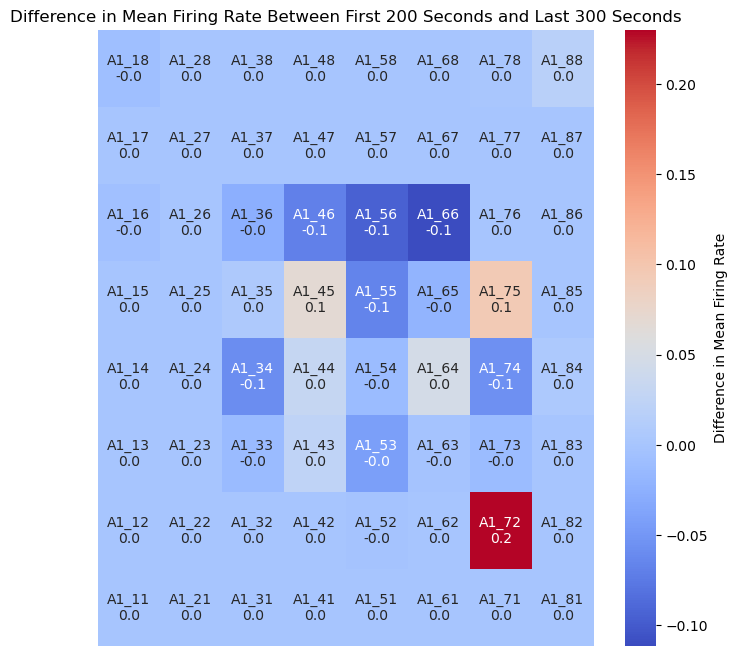

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define segment durations
first_segment_duration = 200  # Duration for the first segment
last_segment_duration = 300  # Duration for the last segment
bin_width = 1  # Assuming bin width is 1 second

# Initialize lists to collect data
all_bins_data = []
all_counts_data = []
first_segment_bins_data = []
first_segment_counts_data = []
last_segment_bins_data = []
last_segment_counts_data = []

# Loop through each column and collect data
for col in columns_to_process:
    bins = sorted_bins[col]
    counts = sorted_counts[col]

    # Calculate segment indices
    first_segment_end_idx = np.searchsorted(bins, first_segment_duration)
    last_segment_start_idx = np.searchsorted(bins, bins[-1] - last_segment_duration + bin_width)

    # Extract segment bins and counts
    first_segment_bins = bins[:first_segment_end_idx]
    first_segment_counts = counts[:first_segment_end_idx]
    last_segment_bins = bins[last_segment_start_idx:]
    last_segment_counts = counts[last_segment_start_idx:]

    # Append data to lists
    all_bins_data.append((col, bins))
    all_counts_data.append((col, counts))
    first_segment_bins_data.append((col, first_segment_bins))
    first_segment_counts_data.append((col, first_segment_counts))
    last_segment_bins_data.append((col, last_segment_bins))
    last_segment_counts_data.append((col, last_segment_counts))

# Define the dtype for the structured arrays
bins_dtype = [('column', 'U50'), ('bins', 'O')]
counts_dtype = [('column', 'U50'), ('counts', 'O')]

# Convert lists to structured np.array
structured_bins_array = np.array(all_bins_data, dtype=bins_dtype)
structured_counts_array = np.array(all_counts_data, dtype=counts_dtype)
first_segment_bins_np_array = np.array(first_segment_bins_data, dtype=bins_dtype)
first_segment_counts_np_array = np.array(first_segment_counts_data, dtype=counts_dtype)
last_segment_bins_np_array = np.array(last_segment_bins_data, dtype=bins_dtype)
last_segment_counts_np_array = np.array(last_segment_counts_data, dtype=counts_dtype)

# Calculate mean firing rates for the first and last segments
first_segment_means_array = [np.mean(first_segment_counts_np_array[i][1]) for i in range(len(columns_to_process))]
last_segment_means_array = [np.mean(last_segment_counts_np_array[i][1]) for i in range(len(columns_to_process))]

# Calculate the difference between the first and last segments
difference_array = np.array(first_segment_means_array) - np.array(last_segment_means_array)

# Determine the size of the reshaped array
num_columns = len(columns_to_process)
side_length = int(np.ceil(np.sqrt(num_columns)))

# Pad the arrays to make them square if necessary
pad_size = side_length**2 - num_columns
difference_array_padded = np.pad(difference_array, (0, pad_size), mode='constant', constant_values=np.nan)
columns_array_padded = np.pad(np.array(columns_to_process), (0, pad_size), mode='constant', constant_values='')

# Reshape the arrays to the determined size
difference_matrix = difference_array_padded.reshape(side_length, side_length)
columns_matrix = columns_array_padded.reshape(side_length, side_length)

# Transpose the matrices to count upwards
difference_matrix = difference_matrix.T
columns_matrix = columns_matrix.T

# Flip the matrices vertically to start from the bottom-left corner
difference_matrix = np.flipud(difference_matrix)
columns_matrix = np.flipud(columns_matrix)

# Create a custom annotation array
annotation_array = np.array([[f'{columns_matrix[i, j]}\n{difference_matrix[i, j]:.1f}' if columns_matrix[i, j] else '' for j in range(side_length)] for i in range(side_length)])

# Create adaptable title based on the durations
difference_plot_title = f'Difference in Mean Firing Rate Between First {first_segment_duration} Seconds and Last {last_segment_duration} Seconds'

# Create a heatmap to visualize the differences with custom annotations
plt.figure(figsize=(8, 8))
sns.heatmap(difference_matrix, annot=annotation_array, fmt='', cmap='coolwarm', cbar_kws={'label': 'Difference in Mean Firing Rate'}, xticklabels=False, yticklabels=False)
plt.title(difference_plot_title)
plt.xlabel('')
plt.ylabel('')
plt.show()